# [NTDS'18] milestone 1: network collection and properties
[ntds'18]: https://github.com/mdeff/ntds_2018

[Effrosyni Simou](https://lts4.epfl.ch/simou), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `7`
* Students: `Mathias Gonçalves Julien Heitmann Mathieu Lamiot Louis Landelle`
* Dataset: `US Senators`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to three sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective 

The purpose of this milestone is to start getting acquainted to the network that you will use for this class. In the first part of the milestone you will import your data using [Pandas](http://pandas.pydata.org) and you will create the adjacency matrix using [Numpy](http://www.numpy.org). This part is project specific. In the second part you will have to compute some basic properties of your network. **For the computation of the properties you are only allowed to use the packages that have been imported in the cell below.** You are not allowed to use any graph-specific toolboxes for this milestone (such as networkx and PyGSP). Furthermore, the aim is not to blindly compute the network properties, but to also start to think about what kind of network you will be working with this semester. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Import json to retrieve the data
import json
#Import requests to send CURL requests to the API. This needs to be installed beforehand
import requests
#Import distances
from scipy.spatial.distance import pdist, squareform

## Part 1 - Import your data and manipulate them. 

###  A. Load your data in a Panda dataframe.

First, you should define and understand what are your nodes, what features you have and what are your labels. Please provide below a Panda dataframe where each row corresponds to a node with its features and labels. For example, in the the case of the Free Music Archive (FMA) Project, each row of the dataframe would be of the following form:


| Track   |  Feature 1  | Feature 2 | . . . | Feature 518|  Label 1 |  Label 2 |. . .|Label 16|
|:-------:|:-----------:|:---------:|:-----:|:----------:|:--------:|:--------:|:---:|:------:|
|         |             |           |       |            |          |          |     |        |

It is possible that in some of the projects either the features or the labels are not available. This is OK, in that case just make sure that you create a dataframe where each of the rows corresponds to a node and its associated features or labels.

In [2]:
#Define a reference function to retrieve data from the API. It returns the "results" object of the retrieved json file.
#You need an API key stored in the APIKey.txt file
def getFromAPI(url):
    with open ("APIKey.txt", "r") as keyFile:
        apiKey=keyFile.readline()
        if apiKey[-1] == '\n':
            apiKey = apiKey[:-1]
            
    headers = {'X-API-Key': apiKey}
    
    r = requests.get(url, headers = headers)
    r = r.json() #Parse the result to a json file
    #print(r['status'])#Should display "Ok"
    
    results = r['results'] #Retrieve the interesting part
    results = results[0]
    
    return results

#This function filters out the senators not in office anymore
def filterActiveSenators(senatorsList):
    senatorActiveList = []
    for senator in senatorsList:
        if senator["in_office"]:
            senatorActiveList.append(senator)
    nbActiveSenators = len(senatorActiveList)
    print("There are " + str(nbActiveSenators) + " active senators among the " + str(len(senatorsList)) + " senators")
    return senatorActiveList

In [3]:
# Parameters

requestsPerSenators = 40; #The number of considered votes will be 20*requestsPerSenators
weights_threshold = 0.5; #Threshold applied to the weights to determine if a link is to be made or not

In [4]:
# Retrieve the list of all senators, filter it and save it
r = getFromAPI("https://api.propublica.org/congress/v1/115/senate/members.json")
senatorsList = r["members"]
senatorActiveList = filterActiveSenators(senatorsList)
DFsenators = pd.io.json.json_normalize(senatorActiveList)

np.save('senatorActiveList',senatorActiveList)

# Build the DataFrames : votesBySenators and votes
jDFvotesBySenators = [] #Dataframe built in a list of dictionnaries
jDFvotes = [] 
uniqueVotes = [];

for senator in senatorActiveList: # For each senator, retrieve his/her votes (features ) and his/her labels
    #For each senator, keep track of his votes in a dictionary and complete the dictionnary with the relevant labels
    senatorDict = senator
    for offset in range(0,requestsPerSenators*20,20): #Retrieve the votes 20 by 20
        r = getFromAPI("https://api.propublica.org/congress/v1/members/"+senator['id']+"/votes.json?offset="+str(offset))
        votes = r['votes'] #List of votes in this range
        for vote in votes: #For each vote in the range, append it to the dictionnary of the senator
            voteID = "S"+vote['session']+"C"+vote['roll_call']
            senatorDict[voteID]=vote['position']
            
            if voteID not in uniqueVotes: #If we never encountered that vote, add it to the jDFvotes
                del vote["member_id"]
                del vote["position"]
                vote["id"] = voteID
                uniqueVotes.append(voteID)
                jDFvotes.append(vote)
    jDFvotesBySenators.append(senatorDict)

DFvotes = pd.io.json.json_normalize(jDFvotes)
DFvotesBySenators = pd.io.json.json_normalize(jDFvotesBySenators)
DFvotesBySenators
DFvotesBySenators.to_pickle('./DFvotesBySenators.pkl')
DFvotes.to_pickle('./DFvotes.pkl')


There are 100 active senators among the 105 senators


In [5]:
features = DFvotesBySenators[uniqueVotes]

labelsList = DFvotesBySenators.columns.tolist()
for x in uniqueVotes:
    labelsList.remove(x)
    
labels = DFvotesBySenators[labelsList]

In [108]:
features = pd.read_pickle("DFvotesBySenators.pkl")
kyl_votes = list(features.loc[54][:-44])

In [109]:
len(kyl_votes)

638

In [100]:
for senator_idx, senator in np.ndenumerate(senatorActiveList):
    flat_idx = senator_idx[0]
    if senator['last_name'] == 'Cruz':
        print(flat_idx)
        print(senator)

23
{'id': 'C001098', 'title': 'Senator, 1st Class', 'short_title': 'Sen.', 'api_uri': 'https://api.propublica.org/congress/v1/members/C001098.json', 'first_name': 'Ted', 'middle_name': None, 'last_name': 'Cruz', 'suffix': None, 'date_of_birth': '1970-12-22', 'gender': 'M', 'party': 'R', 'leadership_role': None, 'twitter_account': 'SenTedCruz', 'facebook_account': 'SenatorTedCruz', 'youtube_account': 'sentedcruz', 'govtrack_id': '412573', 'cspan_id': '1019953', 'votesmart_id': '135705', 'icpsr_id': '41304', 'crp_id': 'N00033085', 'google_entity_id': '/m/07j6ty', 'fec_candidate_id': 'S2TX00312', 'url': 'https://www.cruz.senate.gov', 'rss_url': 'https://www.cruz.senate.gov/rss/', 'contact_form': 'http://www.cruz.senate.gov/?p=email_senator', 'in_office': True, 'dw_nominate': 0.819, 'ideal_point': None, 'seniority': '5', 'next_election': '2018', 'total_votes': 564, 'missed_votes': 32, 'total_present': 0, 'last_updated': '2018-10-17 12:50:35 -0400', 'ocd_id': 'ocd-division/country:us/state:

In [110]:
cruz_votes = list(features.loc[23][:-44])

In [114]:
cruz_votes[-20:]

['Not Voting',
 'Not Voting',
 'Not Voting',
 'Not Voting',
 'Not Voting',
 'Not Voting',
 'Not Voting',
 'No',
 'Yes',
 'Not Voting',
 'No',
 'No',
 'Yes',
 'No',
 'Yes',
 'No',
 'Yes',
 'No',
 'No',
 'Yes']

In [111]:
len(cruz_votes)

638

In [115]:
def numeric_position(position):
    if position == 'Yes':
        return 1.0
    elif position == 'No':
        return 0.0
    else:
        return np.nan    

In [129]:
converted_kyl = np.array(list(map(lambda vote: numeric_position(vote), kyl_votes)))
converted_cruz = np.array(list(map(lambda vote: numeric_position(vote), cruz_votes)))

In [142]:
diff = converted_kyl - converted_cruz
print(638 - (np.isnan(converted_kyl).sum() + np.isnan(converted_cruz).sum()))
print('\n')
print(diff.size)
remove_nan = np.abs(diff[~np.isnan(diff)])
print(remove_nan.size)

344


638
370


In [149]:
disagree_ratio = np.array([remove_nan.sum() / remove_nan.size])
np.exp(-disagree_ratio**2 / kernel_width**2)

array([0.38704849])

In [157]:
c_votes = []
k_votes = []
for offset in range(0,requestsPerSenators*20,20): #Retrieve the votes 20 by 20
    cruz = getFromAPI("https://api.propublica.org/congress/v1/members/"+"C001098"+"/votes.json?offset="+str(offset))
    kyl = getFromAPI("https://api.propublica.org/congress/v1/members/"+"K000352"+"/votes.json?offset="+str(offset))
    c_votes.extend(cruz['votes']) 
    k_votes.extend(kyl['votes'])

In [162]:
c_congress_nbr = list(map(lambda vote: vote['congress'], c_votes))
k_congress_nbr = list(map(lambda vote: vote['congress'], k_votes))

In [173]:
len(list(filter(lambda x: x == '115', k_congress_nbr)))

42

### B. Create the adjacency matrix of your network.

Remember that there are edges connecting the attributed nodes that you organized in the dataframe above. The connectivity of the network is captured by the adjacency matrix $W$. If $N$ is the number of nodes, the adjacency matrix is an $N \times N$ matrix where the value of $W(i,j)$ is the weight of the edge connecting node $i$ to node $j$.  

There are two possible scenarios for your adjacency matrix construction, as you already learned in the tutorial by Benjamin:

1) The edges are given to you explicitly. In this case you should simply load the file containing the edge information and parse it in order to create your adjacency matrix. See how to do that in [this tutorial](../tutorials/02a_graph_from_edge_list.ipynb).

2) The edges are not given to you. In that case you will have to create a feature graph. In order to do that you will have to chose a distance that will quantify how similar two nodes are based on the values in their corresponding feature vectors. [This tutorial](../tutorials/02b_graph_from_features.ipynb) shows you how to build feature graphs when using Euclidean distances between feature vectors. Be curious and explore other distances as well! For instance, in the case of high-dimensional feature vectors, you might want to consider using the cosine distance. Once you compute the distances between your nodes you will have a fully connected network. Do not forget to sparsify by keeping the most important edges in your network.

Follow the appropriate steps for the construction of the adjacency matrix of your network and provide it in the Numpy array ``adjacency`` below: 

In [152]:
#To avoid re-launch the script and all the API queries:
features = pd.read_csv('features.csv')
labels = pd.read_csv('labels.csv')

In [154]:
features

,Unnamed: 0,S2C239,S2C238,S2C237,S2C236,S2C235,S2C234,S2C233,S2C232,S2C231,...,S2C261,S2C260,S2C259,S2C258,S2C257,S2C256,S2C255,S2C254,S2C253,S2C252
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
party = labels['party'].tolist()
np.save('party.npy', np.array(party))

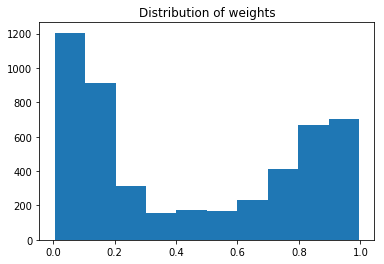

0.2560349575689796
0.0
[[0.         0.         0.95067142 ... 0.74980257 0.         0.59781591]
 [0.         0.         0.         ... 0.         0.65831914 0.        ]
 [0.95067142 0.         0.         ... 0.75455373 0.         0.55587055]
 ...
 [0.74980257 0.         0.75455373 ... 0.         0.         0.90862083]
 [0.         0.65831914 0.         ... 0.         0.         0.        ]
 [0.59781591 0.         0.55587055 ... 0.90862083 0.         0.        ]]
100.0


In [153]:
#Compute the weigths of the network

#Convert features to numbers
features = features.replace('Yes',1)
features = features.replace('No',0)

#All others values should be NaN
cols= features.columns
features[cols] = features[cols].apply(pd.to_numeric, errors='coerce')


#Define a distance ignoring the NaN values
def euclidian_without_NaN(x, y):
    return  np.sqrt(np.nansum(((x-y)**2)))

def l1_normalized_without_NaN(x, y):
    return  np.nansum((np.absolute(x-y)))/np.count_nonzero(~np.isnan(x-y))

distances = pdist(features.values, l1_normalized_without_NaN)

#Distances to weights
kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)



# Turn the list of weights into a matrix.
adjacency = squareform(weights)
#Apply a threshold to the weights to avoid a completely connected network
plt.hist(weights)
plt.title('Distribution of weights')
plt.show()

print(adjacency[54,23])

adjacency[adjacency < weights_threshold] = 0

print(adjacency[54,23])

print(adjacency)

n_nodes = np.sqrt(adjacency.size)
print(n_nodes)

In [61]:
independent = np.where(np.array(party) == 'I')[0]

In [83]:
for independent_idx in independent:
    print(labels.loc[independent_idx])
    print('\n')

52
Unnamed: 0                                                             52
api_uri                 https://api.propublica.org/congress/v1/members...
contact_form                                                          NaN
crp_id                                                          N00034580
cspan_id                                                            37413
date_of_birth                                                  1944-03-31
dw_nominate                                                        -0.152
facebook_account                                      SenatorAngusSKingJr
fax                                                                   NaN
fec_candidate_id                                                S2ME00109
first_name                                                          Angus
gender                                                                  M
google_entity_id                                                /m/02hfx0
govtrack_id                        

In [52]:
print("Disconnected senator info:")
disconnected_idx = (np.where(~adjacency.any(axis=1))[0])[0]
print(adjacency[disconnected_idx])
print('\n')
print(party[disconnected_idx])
print('\n')
print(labels.loc[disconnected_idx])
print('\n')
print(features.loc[disconnected_idx])

Disconnected senator info:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


R


Unnamed: 0                                                             54
api_uri                 https://api.propublica.org/congress/v1/members...
contact_form                                                          NaN
crp_id                                                                NaN
cspan_id                                                              NaN
date_of_birth                                                  1942-04-25
dw_nominate                                                           NaN
facebook_account                                                      NaN
fax                                                                  

In [84]:
disconnected_idx = 52

senatorActiveList = np.load('senatorActiveList.npy')
agree_ratios = []
disconnected_ID = senatorActiveList[disconnected_idx]['id'] 
for senator_idx, senator in np.ndenumerate(senatorActiveList):
    flat_idx = senator_idx[0]
    if flat_idx != disconnected_idx:
        senator_ID = senatorActiveList[flat_idx]['id']
        query_string = "https://api.propublica.org/congress/v1/members/{}/votes/{}/115/senate.json".format(disconnected_ID, senator_ID)
        results = getFromAPI(query_string)
        agree_ratio = results['agree_percent']
        agree_ratios.append(agree_ratio)

In [82]:
# Jon Kyl
agree_ratios.sort()
print(agree_ratios)

[23.81, 26.19, 28.57, 29.27, 30.0, 30.95, 31.71, 31.71, 35.71, 40.48, 40.48, 40.48, 40.48, 40.48, 40.48, 40.48, 40.48, 42.86, 42.86, 42.86, 42.86, 45.24, 45.24, 45.24, 45.24, 45.24, 47.62, 48.48, 48.48, 50.0, 50.0, 50.0, 52.38, 52.38, 52.38, 54.76, 54.76, 56.1, 56.1, 57.14, 58.54, 59.52, 61.9, 69.05, 70.73, 73.81, 73.81, 75.0, 75.0, 80.95, 82.76, 90.24, 91.89, 95.0, 95.0, 95.0, 95.24, 97.37, 97.5, 97.5, 97.56, 97.56, 97.62, 97.62, 97.62, 97.62, 97.62, 97.62, 97.62, 97.62, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


In [85]:
# Angus King
agree_ratios.sort()
print(agree_ratios)

[41.14, 42.99, 45.84, 46.07, 48.49, 49.03, 49.29, 49.53, 49.65, 50.09, 50.28, 50.35, 50.46, 50.53, 50.7, 50.79, 50.8, 51.06, 51.15, 51.23, 51.29, 51.5, 51.58, 51.74, 51.84, 52.13, 52.2, 52.2, 52.38, 52.57, 52.68, 52.73, 52.73, 52.82, 52.9, 52.96, 53.22, 53.27, 53.29, 53.44, 53.45, 53.55, 53.56, 53.6, 53.63, 53.79, 54.09, 54.23, 57.09, 60.11, 60.81, 66.96, 66.97, 68.84, 71.15, 71.48, 71.91, 72.39, 76.28, 77.52, 79.12, 80.17, 80.76, 81.91, 82.52, 82.74, 82.89, 83.0, 83.04, 83.3, 83.3, 83.69, 83.76, 84.05, 84.06, 84.28, 84.72, 84.96, 85.25, 85.54, 85.97, 86.1, 86.19, 86.19, 86.27, 86.57, 87.79, 88.32, 89.33, 89.45, 89.49, 89.73, 90.41, 90.76, 90.79, 92.14, 92.29, 92.35, 92.64]


In [76]:
unity_scores = []
for active_senator in senatorActiveList:
    unity_scores.append((active_senator['votes_with_party_pct'],"{} {}".format(active_senator['first_name'], active_senator['last_name'])))
print(min(unity_scores))

(71.74, 'Joe Manchin')


## Part 2

Execute the cell below to plot the (weighted) adjacency matrix of your network.

Text(0.5, 1.05, 'adjacency matrix')

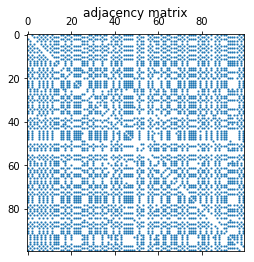

In [10]:
plt.spy(adjacency, markersize=1)
plt.title('adjacency matrix')

### Question 1

What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your network)? How many links $L$ are there in your collected network? Comment on the sparsity of your network.

In [11]:
L = np.count_nonzero(adjacency)/2
print("There are "+str(L)+" links in the network")

There are 2251.0 links in the network


**Your answer here.**

The maximum number of links in an undirected newtork with N nodes, without self-links is N*(N-1)/2. With our network, this means up to 4950 links. We have 2251 links in our network after the thresholding. Hence, we have about half of the possible edges that are actually present in our network.


### Question 2

Is your graph directed or undirected? If it is directed, convert it to an undirected graph by symmetrizing the adjacency matrix.

**Your answer here.**

Our network is already undirected

### Question 3

In the cell below save the features dataframe and the **symmetrized** adjacency matrix. You can use the Pandas ``to_csv`` to save the ``features`` and Numpy's ``save`` to save the ``adjacency``. We will reuse those in the following milestones.

In [12]:
features.to_csv('features.csv')
labels.to_csv('labels.csv')
np.save('adjacency',adjacency)

### Question 4

Are the edges of your graph weighted?

**Your answer here.**

Yes, the weights were constructed from the L1 distances between the features of each senator.

### Question 5

What is the degree distibution of your network? 

In [13]:
degree =  np.sum(adjacency, axis=0)

assert len(degree) == n_nodes

Execute the cell below to see the histogram of the degree distribution.

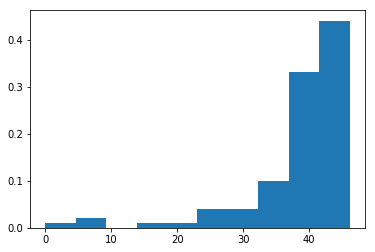

In [14]:
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights);

What is the average degree?

In [15]:
np.mean(degree)

39.044017380732654

### Question 6

Comment on the degree distribution of your network.

**Your answer here.**

The majority of the nodes have a degree close to the average one (between 30 and 45). A few nodes have a very low degree, meaning some nodes are more isolated than the average node. Overall, the degree distribution is quite homogenous.

### Question 7

Write a function that takes as input the adjacency matrix of a graph and determines whether the graph is connected or not.

In [16]:
def connected_graph(adjacency):
    """Determines whether a graph is connected.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    bool
        True if the graph is connected, False otherwise.
    """
    
    # Your code here.
    numOfNodes = adjacency.shape[0]
    
    # Implementation of BFS algorithm
    visited = np.zeros(numOfNodes)
    visited[0] = 1
    queue = np.array([0])
    while (queue.size != 0):
        head = queue[0]
        queue = np.delete(queue, 0)
        for nodeId, isNeibor in enumerate(adjacency[head]):
            if (visited[nodeId] == 0 and isNeibor):
                queue = np.append(queue, nodeId)
                visited[nodeId] = 1
            
    
    
    print(visited)
    return visited.sum() == numOfNodes

Is your graph connected? Run the ``connected_graph`` function to determine your answer.

In [17]:
# Your code here.
connected_graph(adjacency)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


False

The graph is not connencted, senator n°54 has no edges

### Question 8

Write a function that extracts the connected components of a graph.

In [18]:
def bfs(adjacency, node, visited, numOfNodes):
    visitedAux = np.zeros(numOfNodes)
    visited[node] = 1
    visitedAux[node] = 1
    queue = np.array([node])
    while (queue.size != 0):
        head = queue[0]
        queue = np.delete(queue, 0)
        for nodeId, isNeibor in enumerate(adjacency[head]):
            if (visitedAux[nodeId] == 0 and isNeibor):
                queue = np.append(queue, nodeId)
                visitedAux[nodeId] = 1
                visited[nodeId] = 1

    return visitedAux
def find_ids_in_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    numOfNodes = adjacency.shape[0]
    visited = np.zeros(numOfNodes)
    components = []
    while visited.sum() < len(visited):
        node = np.where(visited == 0)[0][0]
        components.append(np.where(bfs(adjacency, node, visited,numOfNodes) == 1)[0])
        
    return components


def find_components(adjacency):
    adjacencies = []
    def dim(x):
        return x.shape[0]
    for ind, ids in enumerate(find_ids_in_components(adjacency)):
        adjacencies.append(adjacency[ids][:,ids])
    return adjacencies#sorted(adjacencies, key=dim, reverse=True)
    

In [19]:
components = find_components(adjacency)
components

[array([[0.        , 0.        , 0.93602331, ..., 0.97760752, 0.        ,
         0.8867102 ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.91592343,
         0.        ],
        [0.93602331, 0.        , 0.        , ..., 0.97280394, 0.        ,
         0.832945  ],
        ...,
        [0.97760752, 0.        , 0.97280394, ..., 0.        , 0.        ,
         0.880055  ],
        [0.        , 0.91592343, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.8867102 , 0.        , 0.832945  , ..., 0.880055  , 0.        ,
         0.        ]]), array([[0.]])]

How many connected components is your network composed of? What is the size of the largest connected component? Run the ``find_components`` function to determine your answer. 

Computes the number of connected components:

In [20]:
numOfComponents = len(components)
print("The number of components is: "+ str(numOfComponents))

The number of components is: 2


Computes the size of the largest component:

In [21]:
largestComponentSize = max(map(lambda x: x.shape[0], components))
print("The size of the largest component is: "+str(largestComponentSize))

The size of the largest component is: 99


### Question 9

Write a function that takes as input the adjacency matrix and a node (`source`) and returns the length of the shortest path between that node and all nodes in the graph using Dijkstra's algorithm. **For the purposes of this assignment we are interested in the hop distance between nodes, not in the sum of weights. **

Hint: You might want to mask the adjacency matrix in the function ``compute_shortest_path_lengths`` in order to make sure you obtain a binary adjacency matrix. 

In [22]:
def adjacencyToBinary(adjacency):
    """ Returns the sign of each element in the adjacency matrix"""
    return np.sign(adjacency)

def compute_shortest_path_lengths(adjacency, source):
    """Compute the shortest path length between a source node and all nodes.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    
    Returns
    -------
    list of ints
        The length of the shortest path from source to all nodes. Returned list should be of length n_nodes.
    """
    # Find the shortest path using DIJSKTRA's algorithm
    numOfNodes = adjacency.shape[0]
    adjacencyBinary = adjacencyToBinary(adjacency)
    dist = np.zeros(numOfNodes)
    dist += float('inf')
    prev = -np.ones(numOfNodes)
    dist[source] = 0
    distAux = dist.copy()
    vertex = np.arange(numOfNodes)
    
    while vertex.size > 0 and np.min(distAux) < float('inf'):
        node = np.argmin(distAux)
        vertex = np.delete(vertex, np.where(vertex == node))
        
        for ind, n in enumerate(adjacencyBinary[node]):
            if (n and (dist[node] + 1 < dist[ind])):
                dist[ind] = dist[node] + 1
                distAux[ind] = distAux[node] + 1
                prev[ind] = node
    
        # Mark node as visited
        distAux[node] = float('inf')
    dist[dist >= 10**300] = float('inf')
    return dist

In [23]:
compute_shortest_path_lengths(adjacency, 0)

array([ 0.,  3.,  1.,  3.,  3.,  1.,  3.,  1.,  3.,  1.,  3.,  1.,  3.,
        3.,  3.,  1.,  1.,  3.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  2.,
        3.,  3.,  1.,  1.,  3.,  1.,  1.,  1.,  3.,  1.,  1.,  4.,  3.,
        1.,  3.,  2.,  1.,  3.,  1.,  1.,  1.,  1.,  1.,  2.,  3.,  1.,
        3.,  3., inf,  1.,  3.,  1.,  2.,  3.,  2.,  1.,  3.,  3.,  1.,
        1.,  3.,  3.,  2.,  1.,  1.,  3.,  1.,  3.,  1.,  1.,  1.,  1.,
        3.,  1.,  3.,  3.,  1.,  3.,  1.,  3.,  3.,  1.,  3.,  1.,  1.,
        1.,  3.,  3.,  3.,  3.,  3.,  1.,  3.,  1.])

### Question 10

The diameter of the graph is the length of the longest shortest path between any pair of nodes. Use the above developed function to compute the diameter of the graph (or the diameter of the largest connected component of the graph if the graph is not connected). If your graph (or largest connected component) is very large, computing the diameter will take very long. In that case downsample your graph so that it has 1.000 nodes. There are many ways to reduce the size of a graph. For the purposes of this milestone you can chose to randomly select 1.000 nodes. 

In [24]:
# Runs the dijskra's algorithm through a connected component from every node and returns the maximum
def diameterOfComponent(adjacency):
    longestPath = np.array([])
    for node in np.arange(adjacency.shape[0]):
        longestPath = np.append(longestPath, compute_shortest_path_lengths(adjacency, node))
    return 0 if len(longestPath)==0 else np.max(longestPath)

# Calls diameterOfComponent method for every component of the graph and returns the maximum
def findDiameter(adjacency):
    longestPaths = np.array([])
    for comp in find_ids_in_components(adjacency):
        longestPaths = np.append(longestPaths, diameterOfComponent(adjacency[comp][:,comp]))
    return 0 if len(longestPaths)==0 else np.max(longestPaths)

In [25]:
diameter = findDiameter(adjacency)
print("The diameter of the graph is: "+str(int(diameter)))

The diameter of the graph is: 4


### Question 11

Write a function that takes as input the adjacency matrix, a path length, and two nodes (`source` and `target`), and returns the number of paths of the given length between them.

In [26]:
def compute_paths(adjacency, source, target, length):
    """Compute the number of paths of a given length between a source and target node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    target: int
        The target node. A number between 0 and n_nodes-1.
    length: int
        The path length to be considered.
    
    Returns
    -------
    int
        The number of paths.
    """
    a_exp = np.linalg.matrix_power(adjacencyToBinary(adjacency), length)    
    return a_exp[source, target]

Test your function on 5 pairs of nodes, with different lengths.

In [27]:
print(compute_paths(adjacency, 0, 10, 1))
print(compute_paths(adjacency, 0, 10, 2))
print(compute_paths(adjacency, 0, 10, 3))
print(compute_paths(adjacency, 23, 67, 2))
print(compute_paths(adjacency, 15, 93, 4))

0.0
0.0
8.0
0.0
411.0


### Question 12

How many paths of length 3 are there in your graph? Hint: calling the `compute_paths` function on every pair of node is not an efficient way to do it.

In [28]:
np.linalg.matrix_power(adjacencyToBinary(adjacency), 3).sum() * .5

4876675.0

### Question 13

Write a function that takes as input the adjacency matrix of your graph (or of the largest connected component of your graph) and a node and returns the clustering coefficient of that node. 

In [29]:
def compute_clustering_coefficient(adjacency, node):
    """Compute the clustering coefficient of a node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    node: int
        The node whose clustering coefficient will be computed. A number between 0 and n_nodes-1.
    
    Returns
    -------
    float
        The clustering coefficient of the node. A number between 0 and 1.
    """
    
    neighbors = np.nonzero(adjacency[node])[0]
    nbr_neighbors = neighbors.size
    total_edges = nbr_neighbors*(nbr_neighbors-1)
    
    neighbor_adjacency = adjacency[neighbors][:,neighbors]
    nbr_edges = neighbor_adjacency.sum()
    
    clustering_coefficient = nbr_edges / total_edges
    
    return clustering_coefficient

### Question 14

What is the average clustering coefficient of your graph (or of the largest connected component of your graph if your graph is disconnected)? Use the function ``compute_clustering_coefficient`` to determine your answer.

In [30]:
# Our graph is disconnected, we should compute the average clustering coefficient 
# of the largest component. 
connected_component = find_components(adjacency)[0]
nbr_nodes = connected_component.shape[0]
avg_clustering_coeff = 0
for index in range(nbr_nodes):
    avg_clustering_coeff += compute_clustering_coefficient(connected_component,index)
    
print("Average clustering coefficient of the largest connected component: {}".format(avg_clustering_coeff/nbr_nodes))

Average clustering coefficient of the largest connected component: 0.8356468423211739
